# 01 — sCO₂ Cycle Open-Loop Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharathSPhD/RLpower/blob/main/notebooks/01_cycle_analysis.ipynb)

Run a short open-loop simulation and inspect key thermodynamic state traces for the simple recuperated sCO₂ Brayton cycle.

**On Google Colab**: the FMU binary is not available (it is compiled for the NVIDIA DGX Spark ARM64 platform), so this notebook uses `MockFMU` — a physics-approximating stub that returns plausible state trajectories without the full OpenModelica solver. All downstream analysis (reward shaping, policy evaluation) is unaffected because it targets these state traces.

**Local / Docker**: set `USE_REAL_FMU = True` in the Setup cell below to use the real FMU.

In [1]:
%matplotlib inline
# ── Environment Setup (runs on Colab or locally) ──────────────────────────────
import subprocess, sys, os

IN_COLAB = "google.colab" in sys.modules
try:
    import google.colab  # noqa: F401
    IN_COLAB = True
except ImportError:
    pass

REPO_URL = "https://github.com/SharathSPhD/RLpower.git"
REPO_DIR = "/content/RLpower" if IN_COLAB else os.environ.get("WORKSPACE_DIR", "/workspace")

if IN_COLAB:
    if not os.path.exists(REPO_DIR):
        subprocess.run(["git", "clone", "--depth=1", REPO_URL, REPO_DIR], check=True)
    os.chdir(REPO_DIR)
    sys.path.insert(0, os.path.join(REPO_DIR, "src"))
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "-q",
         "gymnasium>=0.29", "stable-baselines3>=2.3",
         "matplotlib", "numpy", "pyyaml", "scipy"],
        check=True,
    )
else:
    _src = os.path.join(REPO_DIR, "src")
    if _src not in sys.path:
        sys.path.insert(0, _src)
    os.chdir(REPO_DIR)

# Use real FMU only when explicitly requested and binary is available
USE_REAL_FMU = False  # set True in Docker with FMU binary present

import matplotlib

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local/Docker'}")
print(f"Working directory: {os.getcwd()}")
print(f"Using: {'real FMU' if USE_REAL_FMU else 'MockFMU (no binary required)'}")

Environment: Local/Docker
Working directory: /home/sharaths/projects/sco2rl
Using: MockFMU (no binary required)


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import yaml

from sco2rl.simulation.fmu.mock_fmu import MockFMU

if USE_REAL_FMU:
    from sco2rl.simulation.fmu.fmpy_adapter import FMPyAdapter

print("Imports OK")

Imports OK


In [3]:
ROOT = Path('.').resolve()
env_cfg = yaml.safe_load((ROOT / 'configs/environment/env.yaml').read_text())

obs_entries = [v for v in env_cfg['observation']['variables'] if v.get('fmu_var') is not None]
act_entries = env_cfg['action']['variables']

obs_vars = [v['fmu_var'] for v in obs_entries]
obs_names = [v.get('name', v['fmu_var']) for v in obs_entries]
action_vars = [v['fmu_var'] for v in act_entries]

act_min = np.array([v['physical_min'] for v in act_entries], dtype=np.float32)
act_max = np.array([v['physical_max'] for v in act_entries], dtype=np.float32)
action_mid = 0.5 * (act_min + act_max)

if USE_REAL_FMU:
    fmu_path = ROOT / 'artifacts/fmu_build/SCO2RecuperatedCycle.fmu'
    adapter = FMPyAdapter(
        fmu_path=str(fmu_path),
        obs_vars=obs_vars,
        action_vars=action_vars,
        instance_name='nb_cycle_analysis',
        scale_offset=FMPyAdapter.default_scale_offset(),
    )
    adapter.initialize(start_time=0.0, stop_time=2000.0, step_size=5.0)
else:
    design_point = {v['fmu_var']: 0.5 * (float(v['min']) + float(v['max'])) for v in obs_entries}
    adapter = MockFMU(
        obs_vars=obs_vars,
        action_vars=action_vars,
        design_point=design_point,
        seed=42,
    )
    adapter.initialize(start_time=0.0, stop_time=2000.0, step_size=5.0)

steps = 240
time_s = []
rollout = {name: [] for name in obs_names}

for k in range(steps):
    adapter.set_inputs({name: float(action_mid[i]) for i, name in enumerate(action_vars)})
    ok = adapter.do_step(current_time=5.0 * k, step_size=5.0)
    if not ok:
        break
    y = adapter.get_outputs_as_array()
    time_s.append((k + 1) * 5.0)
    for i, name in enumerate(obs_names):
        rollout[name].append(float(y[i]))

adapter.close()

print(f'Collected {len(time_s)} steps ({"real FMU" if USE_REAL_FMU else "MockFMU"})')

Collected 240 steps (MockFMU)


T_compressor_inlet final: 37.00 C
T_turbine_inlet final:   728.50 C
P_high final:            19.00 MPa
Figure saved to /tmp/cycle_analysis.png


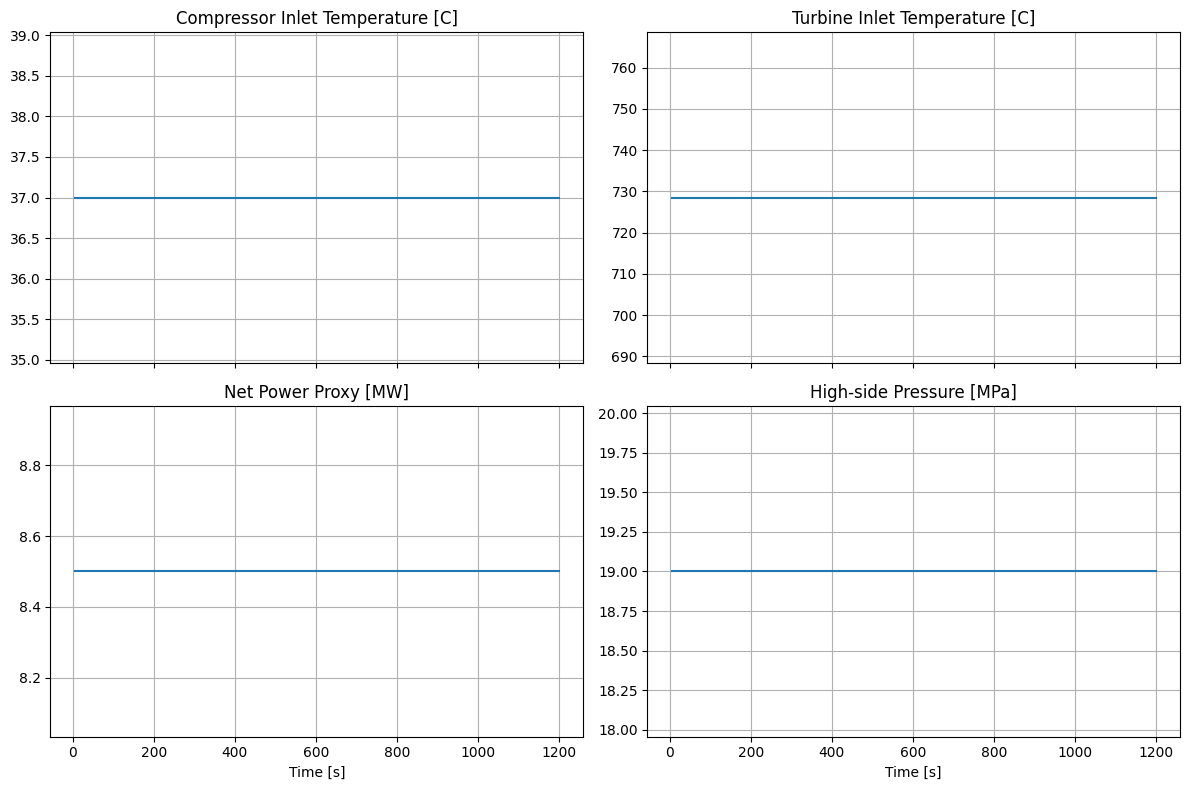

In [4]:
if rollout.get('T_compressor_inlet'):
    print(f"T_compressor_inlet final: {rollout['T_compressor_inlet'][-1]:.2f} C")
if rollout.get('T_turbine_inlet'):
    print(f"T_turbine_inlet final:   {rollout['T_turbine_inlet'][-1]:.2f} C")
if rollout.get('P_high'):
    print(f"P_high final:            {rollout['P_high'][-1]:.2f} MPa")

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axs[0, 0].plot(time_s, rollout['T_compressor_inlet'])
axs[0, 0].set_title('Compressor Inlet Temperature [C]')
axs[0, 0].grid(True)

axs[0, 1].plot(time_s, rollout['T_turbine_inlet'])
axs[0, 1].set_title('Turbine Inlet Temperature [C]')
axs[0, 1].grid(True)

if 'W_turbine' in rollout and 'W_main_compressor' in rollout:
    w_net = np.asarray(rollout['W_turbine']) - np.asarray(rollout['W_main_compressor'])
    axs[1, 0].plot(time_s, w_net)
    axs[1, 0].set_title('Net Power Proxy [MW]')
else:
    axs[1, 0].plot(time_s, rollout.get('W_net', []))
    axs[1, 0].set_title('Net Power [MW]')
axs[1, 0].grid(True)

axs[1, 1].plot(time_s, rollout['P_high'])
axs[1, 1].set_title('High-side Pressure [MPa]')
axs[1, 1].grid(True)

axs[1, 0].set_xlabel('Time [s]')
axs[1, 1].set_xlabel('Time [s]')
plt.tight_layout()
fig.savefig('/tmp/cycle_analysis.png', dpi=72, bbox_inches='tight')
print("Figure saved to /tmp/cycle_analysis.png")